In [ ]:
"""
Spaceship Titanic - Predict Passenger Transport Status
Author: YI LUO
Date: 2025-03-18
Dataset Source: https://www.kaggle.com/competitions/spaceship-titanic/data

📌 Project Overview:
This project aims to build a predictive model to determine whether a passenger was transported to an alternate dimension during the Spaceship Titanic voyage. The dataset was provided by Kaggle and is inspired by the classic Titanic survival prediction problem, but with a science fiction twist.

🎯 Objectives:
- Perform exploratory data analysis (EDA) to uncover patterns and relationships in the data
- Engineer meaningful features from raw data (e.g., extract cabin components, handle missing values)
- Train and evaluate both traditional machine learning (Random Forest) and deep learning (DNN) models
- Compare model performance using validation accuracy and classification metrics
- Generate a Kaggle submission file for evaluation

🔍 Key Data Insights:
- The target variable `Transported` is nearly balanced, which allows for standard classification metrics
- Features like `CryoSleep`, `VIP`, and `Deck` show strong correlation with the transport outcome
- Expenditure-related features (e.g., `Spa`, `VRDeck`) have different distributions between transported and non-transported passengers
- Missing values were handled with median/mode imputation, and cabin information was decomposed into `Deck` and `Side`

🤖 Models Used:
- A baseline **Random Forest Classifier** performed well with minimal tuning and provided valuable feature importance insights
- A **Deep Neural Network (DNN)** was constructed with batch normalization and dropout, showing comparable performance and generalization capability

📁 Deliverables:
- Cleaned and reproducible pipeline
- Visualizations for EDA and model evaluation
- Submission-ready CSV files for Kaggle

This notebook serves as a complete and production-quality example of a full ML pipeline — from data exploration to deployment — and is part of my portfolio for data science job applications.
"""

In [5]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set global plot styles
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
# Load training and test datasets
train = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/train.csv")
test = pd.read_csv("/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/test.csv")

# Display dataset dimensions
print(f"🧩 Train shape: {train.shape}")
print(f"🧪 Test shape: {test.shape}")

# Preview the first few rows of the training set
display(train.head())

# Display data types and number of non-null entries
print("\n📊 Train Info:")
train.info()

# Check for missing values
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\n🔍 Missing values in training data:")
print(missing_values)

🧩 Train shape: (8693, 14)
🧪 Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



📊 Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

🔍 Missing values in training data:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name       

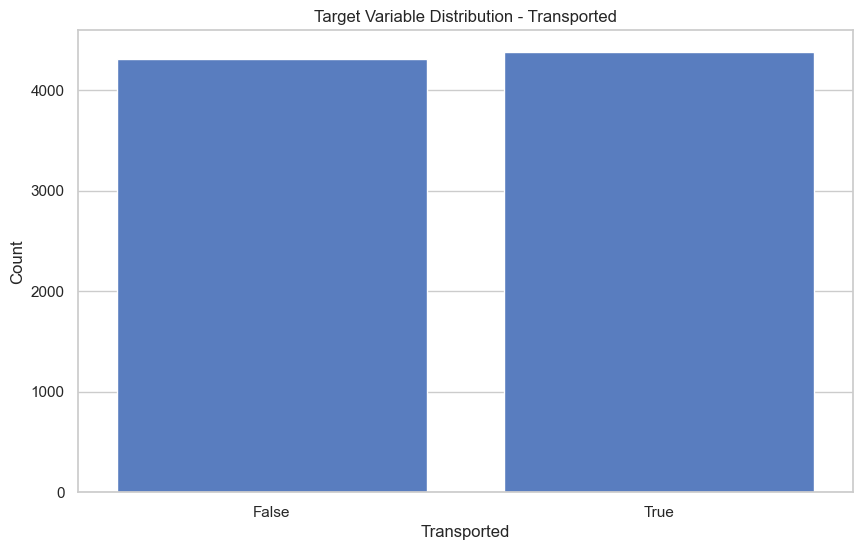

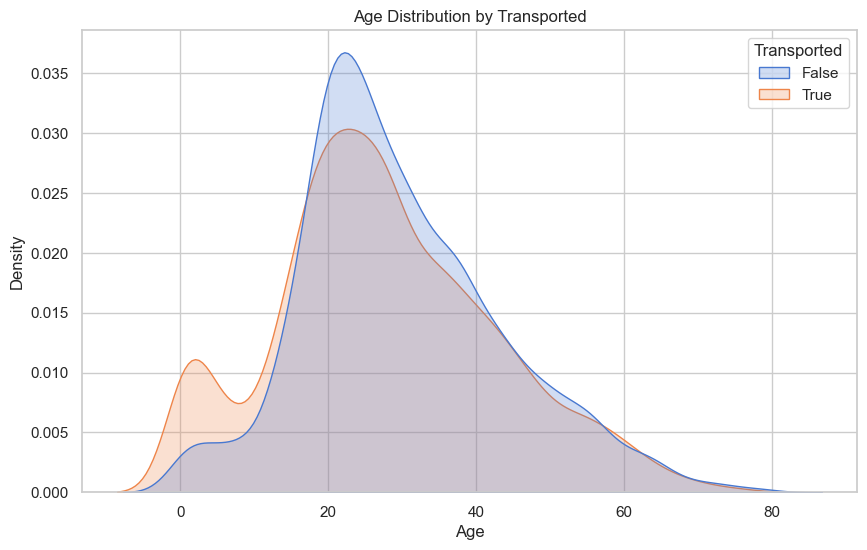

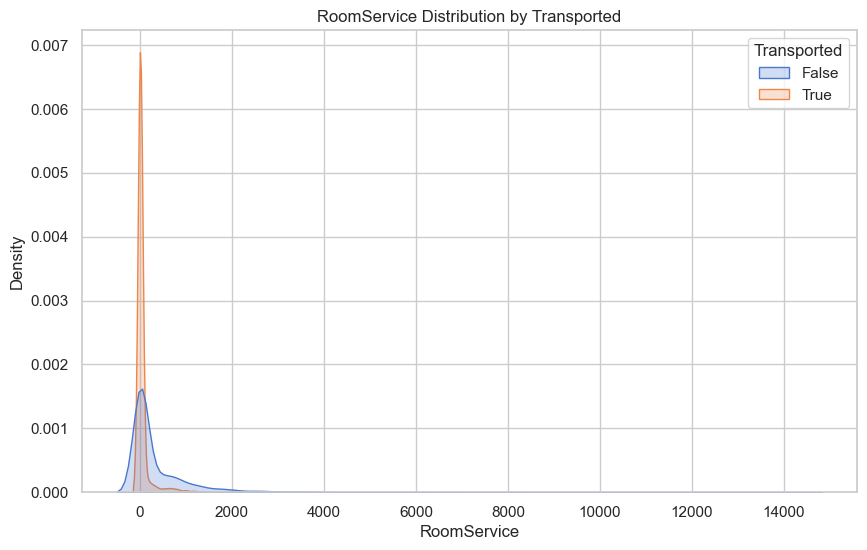

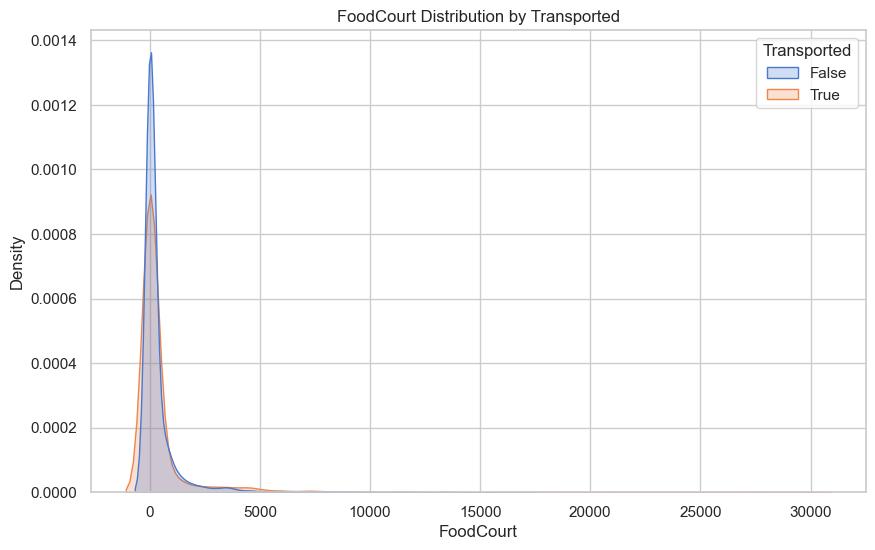

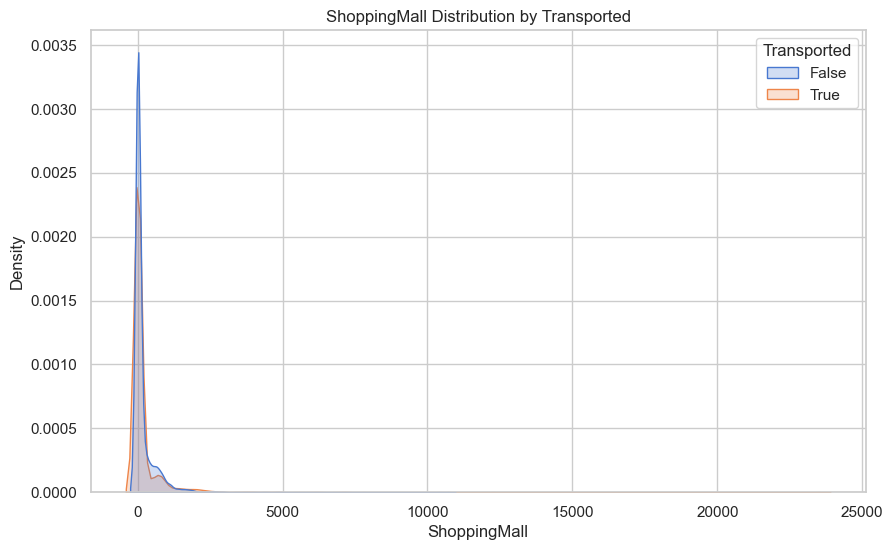

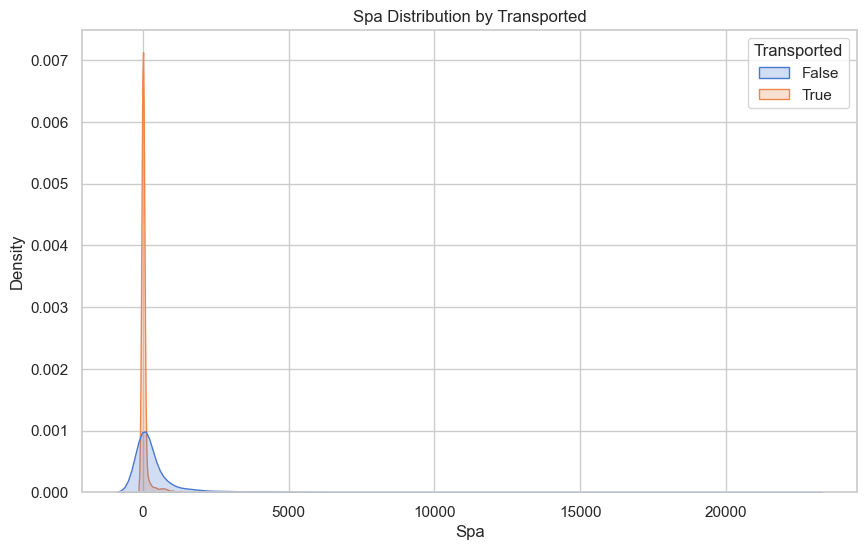

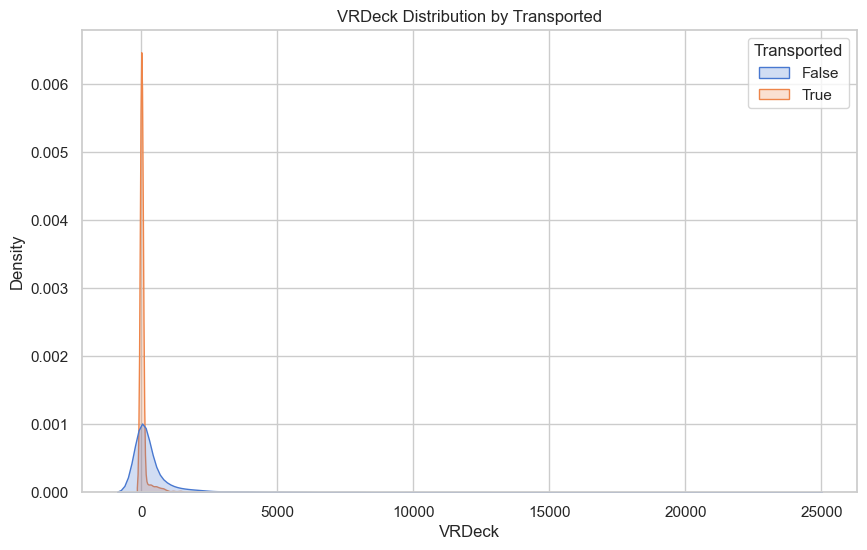

In [8]:
# Check class balance of the target variable
sns.countplot(data=train, x='Transported')
plt.title("Target Variable Distribution - Transported")
plt.xlabel("Transported")
plt.ylabel("Count")
plt.show()

# Plot numerical features vs. Transported
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in numerical_cols:
    sns.kdeplot(data=train, x=col, hue='Transported', fill=True, common_norm=False)
    plt.title(f"{col} Distribution by Transported")
    plt.show()

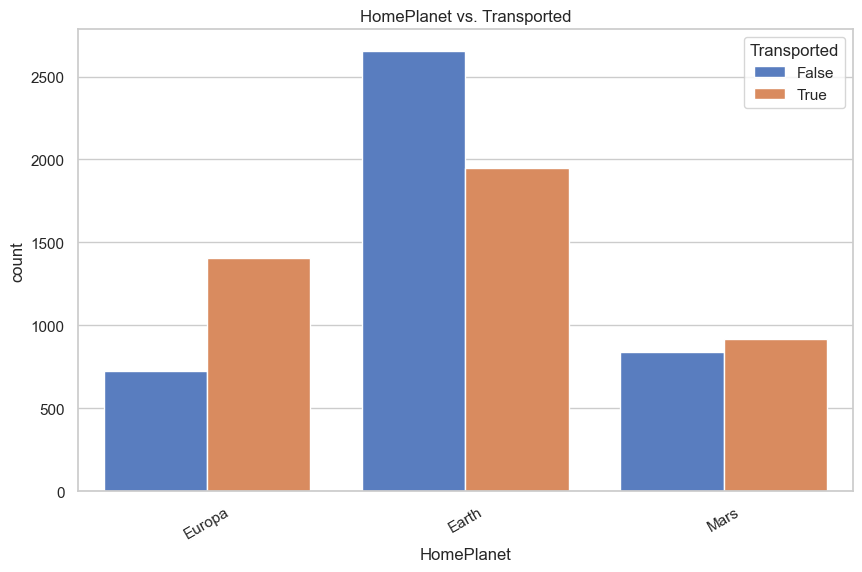

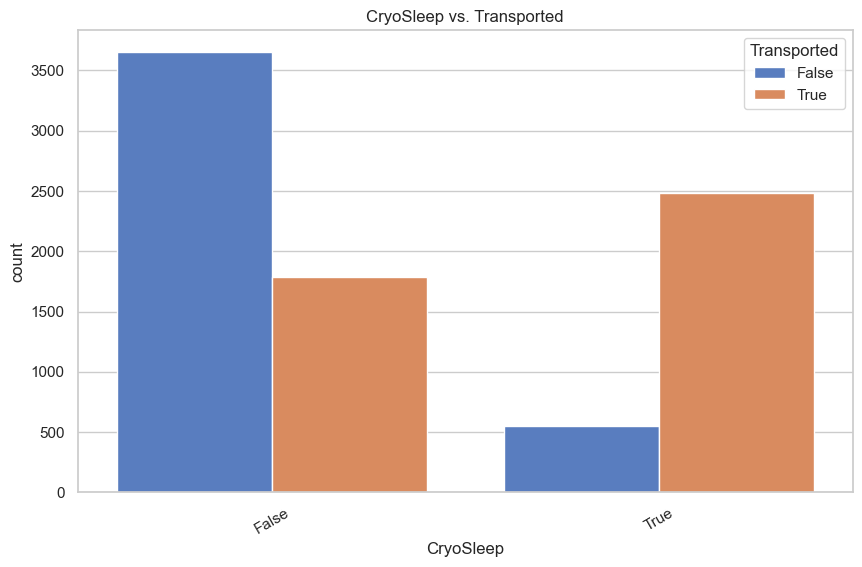

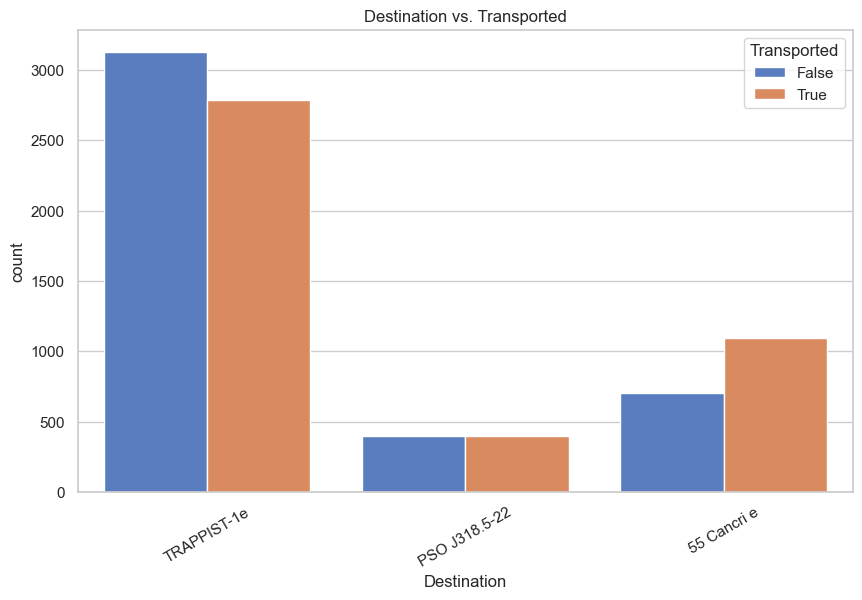

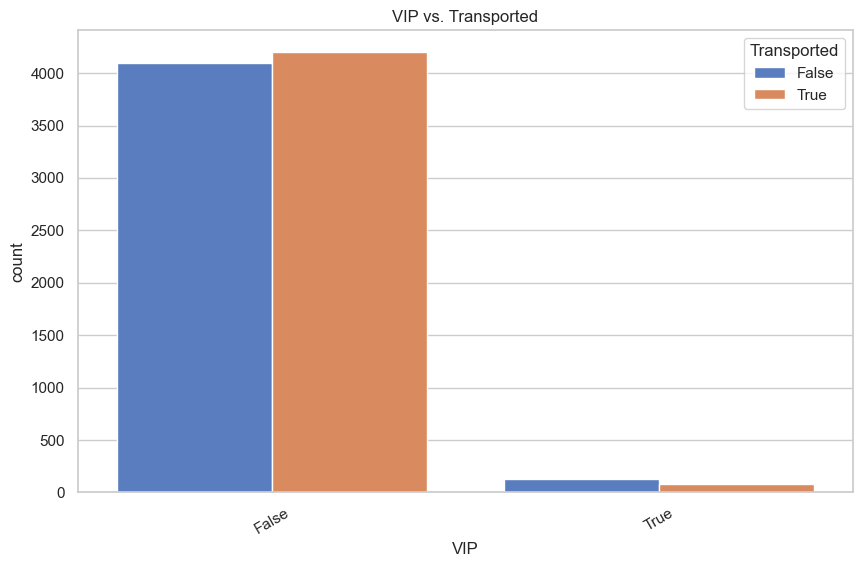

In [9]:
# Categorical columns to examine
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

# Bar plots for categorical features vs. Transported
for col in categorical_cols:
    if col in train.columns:
        sns.countplot(data=train, x=col, hue='Transported')
        plt.title(f"{col} vs. Transported")
        plt.xticks(rotation=30)
        plt.show()

In [17]:
def preprocess_spaceship_data(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """
    Preprocess the Spaceship Titanic dataset:
    - Extracts new features
    - Fills missing values
    - Encodes categorical variables
    - Returns cleaned DataFrame
    """
    # Extract features from 'Cabin' if available
    if 'Cabin' in df.columns:
        df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)

    # Fill missing categorical features
    for col in ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'Deck', 'Side']:
        if col in df.columns:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Define numeric and group columns
    numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    group_cols = ['HomePlanet', 'CryoSleep']

    # Fill missing numerical features
    for col in numerical_cols:
        if col in df.columns:
            # Only group if group columns exist
            if is_train and all(g in df.columns for g in group_cols):
                df[col] = df.groupby(group_cols)[col].transform(lambda x: x.fillna(x.median()))
            else:
                df[col].fillna(df[col].median(), inplace=True)

    # Drop columns that won't be used
    df.drop(columns=['Name', 'Cabin', 'CabinNum'], inplace=True, errors='ignore')

    # One-hot encode remaining categorical features
    categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP']
    df = pd.get_dummies(df, columns=[col for col in categorical_features if col in df.columns], drop_first=True)

    return df

In [18]:
# Clean train and test datasets
train_cleaned = preprocess_spaceship_data(train.copy(), is_train=True)
test_cleaned = preprocess_spaceship_data(test.copy(), is_train=False)

# Extract features and target
X = train_cleaned.drop(columns=['Transported'])
y = train_cleaned['Transported'].astype(int)

# Ensure test has same feature columns
X_test = test_cleaned.reindex(columns=X.columns, fill_value=0)

In [19]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with basic settings
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

✅ Validation Accuracy: 0.8051

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       863
           1       0.84      0.76      0.80       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.80      1739
weighted avg       0.81      0.81      0.80      1739



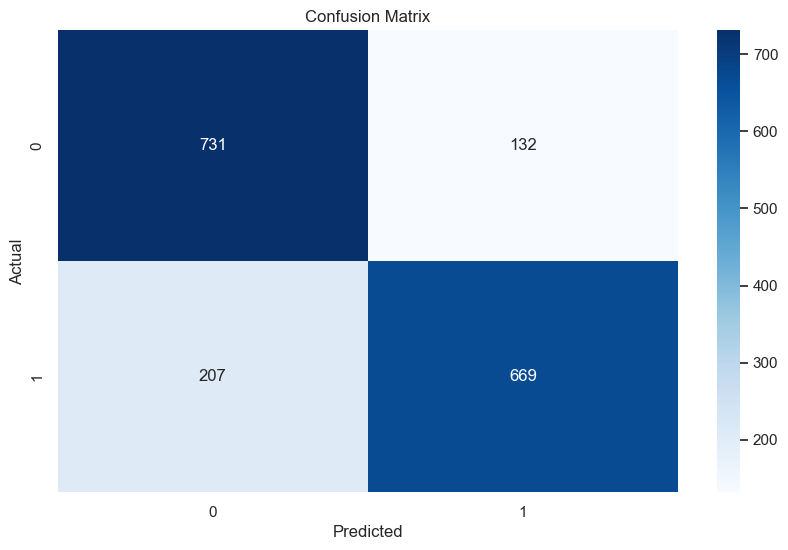

In [21]:
# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Accuracy
val_acc = accuracy_score(y_val, y_val_pred)
print(f"✅ Validation Accuracy: {val_acc:.4f}")

# Confusion matrix and classification report
print("\n📊 Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix plot
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

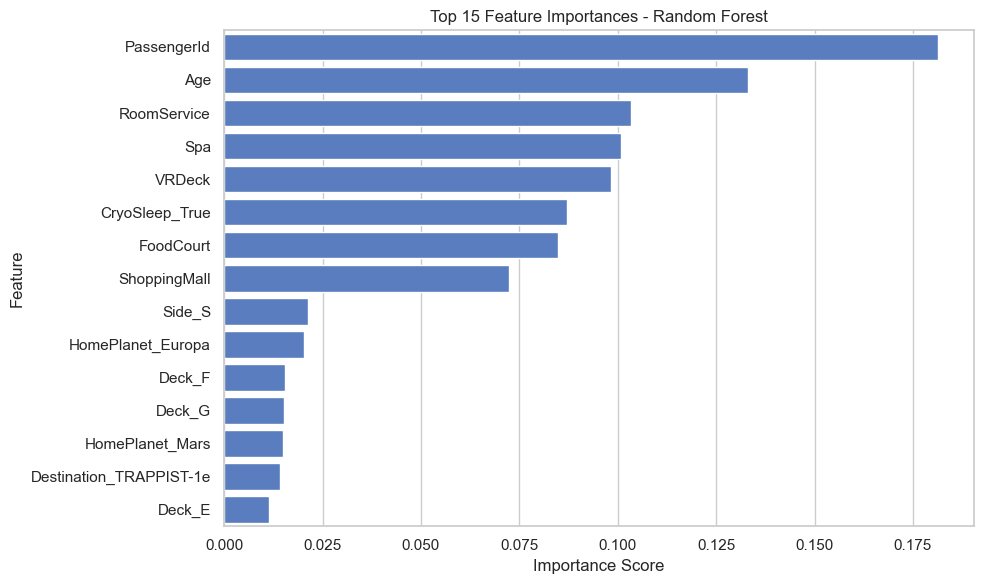

In [22]:
# Get feature importance scores
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

# Plot top 15 important features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx][:15], y=feature_names[sorted_idx][:15])
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
# Predict on test data
test_predictions = rf_model.predict(X_test)

# Use PassengerId from original test set
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Transported": test_predictions.astype(bool)  # Convert to boolean (True/False)
})

# Save to CSV
submission.to_csv("/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_rf.csv", index=False)
print("✅ Submission file saved as '/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_rf.csv'")
submission.head()

✅ Submission file saved as '/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_rf.csv'


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Re-split (to keep consistent with RF section)
X_train_dnn, X_val_dnn, y_train_dnn, y_val_dnn = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for DNNs)
scaler = StandardScaler()
X_train_dnn = scaler.fit_transform(X_train_dnn)
X_val_dnn = scaler.transform(X_val_dnn)
X_test_dnn = scaler.transform(X_test)  # apply same scaling to test data

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build the DNN model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),

    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Add callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4)

# Train
history = model.fit(
    X_train_dnn, y_train_dnn,
    epochs=150,
    batch_size=32,
    validation_data=(X_val_dnn, y_val_dnn),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6837 - loss: 0.5724 - val_accuracy: 0.7757 - val_loss: 0.4381 - learning_rate: 0.0020
Epoch 2/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7740 - loss: 0.4599 - val_accuracy: 0.8010 - val_loss: 0.4045 - learning_rate: 0.0020
Epoch 3/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927 - loss: 0.4365 - val_accuracy: 0.7959 - val_loss: 0.4117 - learning_rate: 0.0020
Epoch 4/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.4226 - val_accuracy: 0.8010 - val_loss: 0.4081 - learning_rate: 0.0020
Epoch 5/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8054 - loss: 0.4256 - val_accuracy: 0.8051 - val_loss: 0.3910 - learning_rate: 0.0020
Epoch 6/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.4243 - val_accuracy: 0.8045 - val_loss: 0.3926 - learning_rate: 0.0020
Epoch 7/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8052 - loss: 0.

In [27]:
# Evaluate
train_loss, train_acc = model.evaluate(X_train_dnn, y_train_dnn, verbose=0)
val_loss, val_acc = model.evaluate(X_val_dnn, y_val_dnn, verbose=0)

print(f"✅ DNN Train Accuracy: {train_acc:.4f}")
print(f"✅ DNN Validation Accuracy: {val_acc:.4f}")

✅ DNN Train Accuracy: 0.8289
✅ DNN Validation Accuracy: 0.8068


In [28]:
# Predict and format for submission
test_probs = model.predict(X_test_dnn)
test_preds = (test_probs > 0.5).astype(bool).flatten()

submission_dnn = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_preds
})

submission_dnn.to_csv('/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_dnn.csv', index=False)
print("✅ DNN submission file saved as '/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_dnn.csv'")
submission_dnn.head()

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
✅ DNN submission file saved as '/Users/luoyi/Desktop/10_kaggle/02_spaceship-titanic/submission_dnn.csv'


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
